# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 1228800/11490434 [==>...........................] - ETA: 0s

 8601600/11490434 [=====================>........] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 16:34 - loss: 0.6931

  15/1875 [..............................] - ETA: 6s - loss: 0.6133   

  29/1875 [..............................] - ETA: 6s - loss: 0.5428

  43/1875 [..............................] - ETA: 6s - loss: 0.4970

  56/1875 [..............................] - ETA: 6s - loss: 0.4672

  69/1875 [>.............................] - ETA: 6s - loss: 0.4451

  81/1875 [>.............................] - ETA: 7s - loss: 0.4288

  94/1875 [>.............................] - ETA: 6s - loss: 0.4144

 110/1875 [>.............................] - ETA: 6s - loss: 0.3998

 128/1875 [=>............................] - ETA: 6s - loss: 0.3864

 149/1875 [=>............................] - ETA: 6s - loss: 0.3734

 171/1875 [=>............................] - ETA: 5s - loss: 0.3621

 191/1875 [==>...........................] - ETA: 5s - loss: 0.3532

 209/1875 [==>...........................] - ETA: 5s - loss: 0.3461

 229/1875 [==>...........................] - ETA: 5s - loss: 0.3391

 250/1875 [===>..........................] - ETA: 5s - loss: 0.3324

 273/1875 [===>..........................] - ETA: 4s - loss: 0.3257

 291/1875 [===>..........................] - ETA: 4s - loss: 0.3210

 310/1875 [===>..........................] - ETA: 4s - loss: 0.3163

 323/1875 [====>.........................] - ETA: 4s - loss: 0.3133

 337/1875 [====>.........................] - ETA: 4s - loss: 0.3102

 353/1875 [====>.........................] - ETA: 4s - loss: 0.3068

 371/1875 [====>.........................] - ETA: 4s - loss: 0.3032

 387/1875 [=====>........................] - ETA: 4s - loss: 0.3002

 405/1875 [=====>........................] - ETA: 4s - loss: 0.2970

 422/1875 [=====>........................] - ETA: 4s - loss: 0.2941

 436/1875 [=====>........................] - ETA: 4s - loss: 0.2918

 452/1875 [======>.......................] - ETA: 4s - loss: 0.2893

 467/1875 [======>.......................] - ETA: 4s - loss: 0.2870

 488/1875 [======>.......................] - ETA: 4s - loss: 0.2840

 501/1875 [=======>......................] - ETA: 4s - loss: 0.2822

 513/1875 [=======>......................] - ETA: 4s - loss: 0.2806

 527/1875 [=======>......................] - ETA: 4s - loss: 0.2787

 546/1875 [=======>......................] - ETA: 4s - loss: 0.2763

 568/1875 [========>.....................] - ETA: 4s - loss: 0.2737

 592/1875 [========>.....................] - ETA: 3s - loss: 0.2709

 611/1875 [========>.....................] - ETA: 3s - loss: 0.2688

 627/1875 [=========>....................] - ETA: 3s - loss: 0.2671

 646/1875 [=========>....................] - ETA: 3s - loss: 0.2652

 659/1875 [=========>....................] - ETA: 3s - loss: 0.2639

 674/1875 [=========>....................] - ETA: 3s - loss: 0.2624

 696/1875 [==========>...................] - ETA: 3s - loss: 0.2603

 714/1875 [==========>...................] - ETA: 3s - loss: 0.2587

 730/1875 [==========>...................] - ETA: 3s - loss: 0.2572

 744/1875 [==========>...................] - ETA: 3s - loss: 0.2560

 758/1875 [===========>..................] - ETA: 3s - loss: 0.2548

 772/1875 [===========>..................] - ETA: 3s - loss: 0.2537

 796/1875 [===========>..................] - ETA: 3s - loss: 0.2517

 818/1875 [============>.................] - ETA: 3s - loss: 0.2500

 839/1875 [============>.................] - ETA: 3s - loss: 0.2484

 852/1875 [============>.................] - ETA: 3s - loss: 0.2475

 866/1875 [============>.................] - ETA: 3s - loss: 0.2465

 881/1875 [=============>................] - ETA: 3s - loss: 0.2454

 891/1875 [=============>................] - ETA: 3s - loss: 0.2447

 904/1875 [=============>................] - ETA: 2s - loss: 0.2438

 920/1875 [=============>................] - ETA: 2s - loss: 0.2428

 934/1875 [=============>................] - ETA: 2s - loss: 0.2418

 950/1875 [==============>...............] - ETA: 2s - loss: 0.2408

 967/1875 [==============>...............] - ETA: 2s - loss: 0.2397

 987/1875 [==============>...............] - ETA: 2s - loss: 0.2385

1010/1875 [===============>..............] - ETA: 2s - loss: 0.2371

1028/1875 [===============>..............] - ETA: 2s - loss: 0.2361

1045/1875 [===============>..............] - ETA: 2s - loss: 0.2351

1066/1875 [================>.............] - ETA: 2s - loss: 0.2339

1080/1875 [================>.............] - ETA: 2s - loss: 0.2331

1095/1875 [================>.............] - ETA: 2s - loss: 0.2323

1117/1875 [================>.............] - ETA: 2s - loss: 0.2311

1137/1875 [=================>............] - ETA: 2s - loss: 0.2301

1156/1875 [=================>............] - ETA: 2s - loss: 0.2291

1171/1875 [=================>............] - ETA: 2s - loss: 0.2284

1189/1875 [==================>...........] - ETA: 2s - loss: 0.2275

1206/1875 [==================>...........] - ETA: 2s - loss: 0.2267

1223/1875 [==================>...........] - ETA: 1s - loss: 0.2259

1239/1875 [==================>...........] - ETA: 1s - loss: 0.2251

1255/1875 [===================>..........] - ETA: 1s - loss: 0.2244

1273/1875 [===================>..........] - ETA: 1s - loss: 0.2236

1285/1875 [===================>..........] - ETA: 1s - loss: 0.2230

1303/1875 [===================>..........] - ETA: 1s - loss: 0.2222

1318/1875 [====================>.........] - ETA: 1s - loss: 0.2216

1329/1875 [====================>.........] - ETA: 1s - loss: 0.2211

1346/1875 [====================>.........] - ETA: 1s - loss: 0.2204

1359/1875 [====================>.........] - ETA: 1s - loss: 0.2199

1372/1875 [====================>.........] - ETA: 1s - loss: 0.2193

1383/1875 [=====================>........] - ETA: 1s - loss: 0.2189

1397/1875 [=====================>........] - ETA: 1s - loss: 0.2183

1409/1875 [=====================>........] - ETA: 1s - loss: 0.2178

1419/1875 [=====================>........] - ETA: 1s - loss: 0.2174

1437/1875 [=====================>........] - ETA: 1s - loss: 0.2167

1451/1875 [======================>.......] - ETA: 1s - loss: 0.2162

1466/1875 [======================>.......] - ETA: 1s - loss: 0.2156

1481/1875 [======================>.......] - ETA: 1s - loss: 0.2151

1494/1875 [======================>.......] - ETA: 1s - loss: 0.2146

1507/1875 [=======================>......] - ETA: 1s - loss: 0.2141

1521/1875 [=======================>......] - ETA: 1s - loss: 0.2136

1533/1875 [=======================>......] - ETA: 1s - loss: 0.2132

1545/1875 [=======================>......] - ETA: 1s - loss: 0.2128

1558/1875 [=======================>......] - ETA: 1s - loss: 0.2123

1571/1875 [========================>.....] - ETA: 0s - loss: 0.2118

1587/1875 [========================>.....] - ETA: 0s - loss: 0.2113

1604/1875 [========================>.....] - ETA: 0s - loss: 0.2107

1617/1875 [========================>.....] - ETA: 0s - loss: 0.2103

1630/1875 [=========================>....] - ETA: 0s - loss: 0.2098

1644/1875 [=========================>....] - ETA: 0s - loss: 0.2094

1657/1875 [=========================>....] - ETA: 0s - loss: 0.2090

1668/1875 [=========================>....] - ETA: 0s - loss: 0.2086

1683/1875 [=========================>....] - ETA: 0s - loss: 0.2081

1698/1875 [==========================>...] - ETA: 0s - loss: 0.2076

1710/1875 [==========================>...] - ETA: 0s - loss: 0.2073

1723/1875 [==========================>...] - ETA: 0s - loss: 0.2069

1737/1875 [==========================>...] - ETA: 0s - loss: 0.2064

1751/1875 [===========================>..] - ETA: 0s - loss: 0.2060

1768/1875 [===========================>..] - ETA: 0s - loss: 0.2055

1782/1875 [===========================>..] - ETA: 0s - loss: 0.2051

1797/1875 [===========================>..] - ETA: 0s - loss: 0.2046

1812/1875 [===========================>..] - ETA: 0s - loss: 0.2042

1827/1875 [============================>.] - ETA: 0s - loss: 0.2037

1841/1875 [============================>.] - ETA: 0s - loss: 0.2033

1858/1875 [============================>.] - ETA: 0s - loss: 0.2029

1873/1875 [============================>.] - ETA: 0s - loss: 0.2024

1875/1875 [==============================] - 7s 3ms/step - loss: 0.2024


Epoch 2/5
   1/1875 [..............................] - ETA: 6s - loss: 0.0919

  12/1875 [..............................] - ETA: 8s - loss: 0.1052

  26/1875 [..............................] - ETA: 7s - loss: 0.1074

  40/1875 [..............................] - ETA: 7s - loss: 0.1078

  53/1875 [..............................] - ETA: 7s - loss: 0.1080

  69/1875 [>.............................] - ETA: 6s - loss: 0.1081

  83/1875 [>.............................] - ETA: 6s - loss: 0.1083

  96/1875 [>.............................] - ETA: 6s - loss: 0.1085

 110/1875 [>.............................] - ETA: 6s - loss: 0.1087

 122/1875 [>.............................] - ETA: 6s - loss: 0.1088

 135/1875 [=>............................] - ETA: 6s - loss: 0.1089

 150/1875 [=>............................] - ETA: 6s - loss: 0.1089

 162/1875 [=>............................] - ETA: 6s - loss: 0.1089

 173/1875 [=>............................] - ETA: 6s - loss: 0.1089

 192/1875 [==>...........................] - ETA: 6s - loss: 0.1090

 207/1875 [==>...........................] - ETA: 6s - loss: 0.1090

 218/1875 [==>...........................] - ETA: 6s - loss: 0.1090

 232/1875 [==>...........................] - ETA: 6s - loss: 0.1090

 247/1875 [==>...........................] - ETA: 6s - loss: 0.1089

 264/1875 [===>..........................] - ETA: 6s - loss: 0.1089

 275/1875 [===>..........................] - ETA: 6s - loss: 0.1089

 288/1875 [===>..........................] - ETA: 6s - loss: 0.1089

 298/1875 [===>..........................] - ETA: 6s - loss: 0.1089

 314/1875 [====>.........................] - ETA: 5s - loss: 0.1088

 325/1875 [====>.........................] - ETA: 5s - loss: 0.1088

 339/1875 [====>.........................] - ETA: 5s - loss: 0.1088

 352/1875 [====>.........................] - ETA: 5s - loss: 0.1088

 363/1875 [====>.........................] - ETA: 5s - loss: 0.1087

 377/1875 [=====>........................] - ETA: 5s - loss: 0.1087

 386/1875 [=====>........................] - ETA: 5s - loss: 0.1087

 398/1875 [=====>........................] - ETA: 5s - loss: 0.1086

 413/1875 [=====>........................] - ETA: 5s - loss: 0.1086

 428/1875 [=====>........................] - ETA: 5s - loss: 0.1086

 444/1875 [======>.......................] - ETA: 5s - loss: 0.1085

 460/1875 [======>.......................] - ETA: 5s - loss: 0.1085

 475/1875 [======>.......................] - ETA: 5s - loss: 0.1084

 484/1875 [======>.......................] - ETA: 5s - loss: 0.1084

 499/1875 [======>.......................] - ETA: 5s - loss: 0.1084

 511/1875 [=======>......................] - ETA: 5s - loss: 0.1083

 522/1875 [=======>......................] - ETA: 5s - loss: 0.1083

 537/1875 [=======>......................] - ETA: 5s - loss: 0.1083

 551/1875 [=======>......................] - ETA: 5s - loss: 0.1082

 565/1875 [========>.....................] - ETA: 5s - loss: 0.1082

 577/1875 [========>.....................] - ETA: 5s - loss: 0.1081

 591/1875 [========>.....................] - ETA: 4s - loss: 0.1081

 605/1875 [========>.....................] - ETA: 4s - loss: 0.1081

 623/1875 [========>.....................] - ETA: 4s - loss: 0.1080

 637/1875 [=========>....................] - ETA: 4s - loss: 0.1080

 654/1875 [=========>....................] - ETA: 4s - loss: 0.1080

 666/1875 [=========>....................] - ETA: 4s - loss: 0.1079

 681/1875 [=========>....................] - ETA: 4s - loss: 0.1079

 699/1875 [==========>...................] - ETA: 4s - loss: 0.1079

 710/1875 [==========>...................] - ETA: 4s - loss: 0.1078

 720/1875 [==========>...................] - ETA: 4s - loss: 0.1078

 732/1875 [==========>...................] - ETA: 4s - loss: 0.1078

 745/1875 [==========>...................] - ETA: 4s - loss: 0.1077

 755/1875 [===========>..................] - ETA: 4s - loss: 0.1077

 767/1875 [===========>..................] - ETA: 4s - loss: 0.1077

 779/1875 [===========>..................] - ETA: 4s - loss: 0.1077

 792/1875 [===========>..................] - ETA: 4s - loss: 0.1076

 805/1875 [===========>..................] - ETA: 4s - loss: 0.1076

 818/1875 [============>.................] - ETA: 4s - loss: 0.1076

 832/1875 [============>.................] - ETA: 4s - loss: 0.1075

 846/1875 [============>.................] - ETA: 4s - loss: 0.1075

 860/1875 [============>.................] - ETA: 3s - loss: 0.1075

 874/1875 [============>.................] - ETA: 3s - loss: 0.1074

 887/1875 [=============>................] - ETA: 3s - loss: 0.1074

 900/1875 [=============>................] - ETA: 3s - loss: 0.1074

 917/1875 [=============>................] - ETA: 3s - loss: 0.1074

 931/1875 [=============>................] - ETA: 3s - loss: 0.1073

 945/1875 [==============>...............] - ETA: 3s - loss: 0.1073

 960/1875 [==============>...............] - ETA: 3s - loss: 0.1073

 973/1875 [==============>...............] - ETA: 3s - loss: 0.1072

 986/1875 [==============>...............] - ETA: 3s - loss: 0.1072

1003/1875 [===============>..............] - ETA: 3s - loss: 0.1072

1016/1875 [===============>..............] - ETA: 3s - loss: 0.1072

1029/1875 [===============>..............] - ETA: 3s - loss: 0.1071

1042/1875 [===============>..............] - ETA: 3s - loss: 0.1071

1055/1875 [===============>..............] - ETA: 3s - loss: 0.1071

1073/1875 [================>.............] - ETA: 3s - loss: 0.1070

1089/1875 [================>.............] - ETA: 3s - loss: 0.1070

1104/1875 [================>.............] - ETA: 2s - loss: 0.1070

1117/1875 [================>.............] - ETA: 2s - loss: 0.1070

1130/1875 [=================>............] - ETA: 2s - loss: 0.1069

1144/1875 [=================>............] - ETA: 2s - loss: 0.1069

1159/1875 [=================>............] - ETA: 2s - loss: 0.1069

1174/1875 [=================>............] - ETA: 2s - loss: 0.1068

1187/1875 [=================>............] - ETA: 2s - loss: 0.1068

1203/1875 [==================>...........] - ETA: 2s - loss: 0.1068

1218/1875 [==================>...........] - ETA: 2s - loss: 0.1068

1231/1875 [==================>...........] - ETA: 2s - loss: 0.1067

1248/1875 [==================>...........] - ETA: 2s - loss: 0.1067

1261/1875 [===================>..........] - ETA: 2s - loss: 0.1067

1275/1875 [===================>..........] - ETA: 2s - loss: 0.1067

1288/1875 [===================>..........] - ETA: 2s - loss: 0.1066

1302/1875 [===================>..........] - ETA: 2s - loss: 0.1066

1315/1875 [====================>.........] - ETA: 2s - loss: 0.1066

1331/1875 [====================>.........] - ETA: 2s - loss: 0.1066

1342/1875 [====================>.........] - ETA: 2s - loss: 0.1065

1355/1875 [====================>.........] - ETA: 1s - loss: 0.1065

1370/1875 [====================>.........] - ETA: 1s - loss: 0.1065

1383/1875 [=====================>........] - ETA: 1s - loss: 0.1065

1398/1875 [=====================>........] - ETA: 1s - loss: 0.1064

1417/1875 [=====================>........] - ETA: 1s - loss: 0.1064

1432/1875 [=====================>........] - ETA: 1s - loss: 0.1064

1449/1875 [======================>.......] - ETA: 1s - loss: 0.1063

1465/1875 [======================>.......] - ETA: 1s - loss: 0.1063

1480/1875 [======================>.......] - ETA: 1s - loss: 0.1063

1493/1875 [======================>.......] - ETA: 1s - loss: 0.1063

1510/1875 [=======================>......] - ETA: 1s - loss: 0.1062

1525/1875 [=======================>......] - ETA: 1s - loss: 0.1062

1540/1875 [=======================>......] - ETA: 1s - loss: 0.1062

1553/1875 [=======================>......] - ETA: 1s - loss: 0.1062

1562/1875 [=======================>......] - ETA: 1s - loss: 0.1061

1579/1875 [========================>.....] - ETA: 1s - loss: 0.1061

1594/1875 [========================>.....] - ETA: 1s - loss: 0.1061

1604/1875 [========================>.....] - ETA: 1s - loss: 0.1061

1618/1875 [========================>.....] - ETA: 0s - loss: 0.1060

1628/1875 [=========================>....] - ETA: 0s - loss: 0.1060

1638/1875 [=========================>....] - ETA: 0s - loss: 0.1060

1652/1875 [=========================>....] - ETA: 0s - loss: 0.1060

1662/1875 [=========================>....] - ETA: 0s - loss: 0.1060

1677/1875 [=========================>....] - ETA: 0s - loss: 0.1060

1690/1875 [==========================>...] - ETA: 0s - loss: 0.1059

1704/1875 [==========================>...] - ETA: 0s - loss: 0.1059

1719/1875 [==========================>...] - ETA: 0s - loss: 0.1059

1736/1875 [==========================>...] - ETA: 0s - loss: 0.1059

1751/1875 [===========================>..] - ETA: 0s - loss: 0.1058

1765/1875 [===========================>..] - ETA: 0s - loss: 0.1058

1779/1875 [===========================>..] - ETA: 0s - loss: 0.1058

1793/1875 [===========================>..] - ETA: 0s - loss: 0.1058

1807/1875 [===========================>..] - ETA: 0s - loss: 0.1057

1824/1875 [============================>.] - ETA: 0s - loss: 0.1057

1838/1875 [============================>.] - ETA: 0s - loss: 0.1057

1852/1875 [============================>.] - ETA: 0s - loss: 0.1057

1867/1875 [============================>.] - ETA: 0s - loss: 0.1057

1875/1875 [==============================] - 7s 4ms/step - loss: 0.1056


Epoch 3/5
   1/1875 [..............................] - ETA: 8s - loss: 0.1007

  13/1875 [..............................] - ETA: 8s - loss: 0.1021

  28/1875 [..............................] - ETA: 7s - loss: 0.1016

  43/1875 [..............................] - ETA: 6s - loss: 0.1010

  57/1875 [..............................] - ETA: 6s - loss: 0.1006

  71/1875 [>.............................] - ETA: 6s - loss: 0.1003

  86/1875 [>.............................] - ETA: 6s - loss: 0.1000

 101/1875 [>.............................] - ETA: 6s - loss: 0.0997

 115/1875 [>.............................] - ETA: 6s - loss: 0.0995

 129/1875 [=>............................] - ETA: 6s - loss: 0.0994

 142/1875 [=>............................] - ETA: 6s - loss: 0.0993

 157/1875 [=>............................] - ETA: 6s - loss: 0.0992

 171/1875 [=>............................] - ETA: 6s - loss: 0.0991

 187/1875 [=>............................] - ETA: 6s - loss: 0.0990

 201/1875 [==>...........................] - ETA: 6s - loss: 0.0990

 215/1875 [==>...........................] - ETA: 6s - loss: 0.0989

 229/1875 [==>...........................] - ETA: 6s - loss: 0.0989

 244/1875 [==>...........................] - ETA: 5s - loss: 0.0989

 256/1875 [===>..........................] - ETA: 5s - loss: 0.0988

 273/1875 [===>..........................] - ETA: 5s - loss: 0.0988

 287/1875 [===>..........................] - ETA: 5s - loss: 0.0988

 297/1875 [===>..........................] - ETA: 5s - loss: 0.0988

 309/1875 [===>..........................] - ETA: 5s - loss: 0.0987

 323/1875 [====>.........................] - ETA: 5s - loss: 0.0987

 336/1875 [====>.........................] - ETA: 5s - loss: 0.0987

 352/1875 [====>.........................] - ETA: 5s - loss: 0.0987

 366/1875 [====>.........................] - ETA: 5s - loss: 0.0987

 379/1875 [=====>........................] - ETA: 5s - loss: 0.0986

 393/1875 [=====>........................] - ETA: 5s - loss: 0.0986

 409/1875 [=====>........................] - ETA: 5s - loss: 0.0986

 429/1875 [=====>........................] - ETA: 5s - loss: 0.0986

 444/1875 [======>.......................] - ETA: 5s - loss: 0.0986

 455/1875 [======>.......................] - ETA: 5s - loss: 0.0986

 465/1875 [======>.......................] - ETA: 5s - loss: 0.0986

 476/1875 [======>.......................] - ETA: 5s - loss: 0.0986

 490/1875 [======>.......................] - ETA: 5s - loss: 0.0985

 507/1875 [=======>......................] - ETA: 5s - loss: 0.0985

 523/1875 [=======>......................] - ETA: 5s - loss: 0.0985

 538/1875 [=======>......................] - ETA: 4s - loss: 0.0985

 552/1875 [=======>......................] - ETA: 4s - loss: 0.0985

 567/1875 [========>.....................] - ETA: 4s - loss: 0.0985

 582/1875 [========>.....................] - ETA: 4s - loss: 0.0985

 596/1875 [========>.....................] - ETA: 4s - loss: 0.0985

 608/1875 [========>.....................] - ETA: 4s - loss: 0.0985

 623/1875 [========>.....................] - ETA: 4s - loss: 0.0984

 635/1875 [=========>....................] - ETA: 4s - loss: 0.0984

 649/1875 [=========>....................] - ETA: 4s - loss: 0.0984

 665/1875 [=========>....................] - ETA: 4s - loss: 0.0984

 680/1875 [=========>....................] - ETA: 4s - loss: 0.0984

 694/1875 [==========>...................] - ETA: 4s - loss: 0.0984

 708/1875 [==========>...................] - ETA: 4s - loss: 0.0984

 721/1875 [==========>...................] - ETA: 4s - loss: 0.0984

 733/1875 [==========>...................] - ETA: 4s - loss: 0.0984

 745/1875 [==========>...................] - ETA: 4s - loss: 0.0984

 757/1875 [===========>..................] - ETA: 4s - loss: 0.0984

 769/1875 [===========>..................] - ETA: 4s - loss: 0.0984

 783/1875 [===========>..................] - ETA: 4s - loss: 0.0984

 796/1875 [===========>..................] - ETA: 4s - loss: 0.0984

 808/1875 [===========>..................] - ETA: 4s - loss: 0.0984

 823/1875 [============>.................] - ETA: 3s - loss: 0.0983

 834/1875 [============>.................] - ETA: 3s - loss: 0.0983

 847/1875 [============>.................] - ETA: 3s - loss: 0.0983

 861/1875 [============>.................] - ETA: 3s - loss: 0.0983

 874/1875 [============>.................] - ETA: 3s - loss: 0.0983

 887/1875 [=============>................] - ETA: 3s - loss: 0.0983

 903/1875 [=============>................] - ETA: 3s - loss: 0.0983

 916/1875 [=============>................] - ETA: 3s - loss: 0.0983

 929/1875 [=============>................] - ETA: 3s - loss: 0.0983

 943/1875 [==============>...............] - ETA: 3s - loss: 0.0983

 956/1875 [==============>...............] - ETA: 3s - loss: 0.0983

 969/1875 [==============>...............] - ETA: 3s - loss: 0.0983

 983/1875 [==============>...............] - ETA: 3s - loss: 0.0983

 996/1875 [==============>...............] - ETA: 3s - loss: 0.0983

1009/1875 [===============>..............] - ETA: 3s - loss: 0.0983

1023/1875 [===============>..............] - ETA: 3s - loss: 0.0983

1037/1875 [===============>..............] - ETA: 3s - loss: 0.0983

1051/1875 [===============>..............] - ETA: 3s - loss: 0.0983

1068/1875 [================>.............] - ETA: 3s - loss: 0.0983

1082/1875 [================>.............] - ETA: 2s - loss: 0.0982

1096/1875 [================>.............] - ETA: 2s - loss: 0.0982

1111/1875 [================>.............] - ETA: 2s - loss: 0.0982

1125/1875 [=================>............] - ETA: 2s - loss: 0.0982

1140/1875 [=================>............] - ETA: 2s - loss: 0.0982

1157/1875 [=================>............] - ETA: 2s - loss: 0.0982

1172/1875 [=================>............] - ETA: 2s - loss: 0.0982

1187/1875 [=================>............] - ETA: 2s - loss: 0.0982

1202/1875 [==================>...........] - ETA: 2s - loss: 0.0982

1216/1875 [==================>...........] - ETA: 2s - loss: 0.0982

1231/1875 [==================>...........] - ETA: 2s - loss: 0.0982

1246/1875 [==================>...........] - ETA: 2s - loss: 0.0982

1261/1875 [===================>..........] - ETA: 2s - loss: 0.0982

1275/1875 [===================>..........] - ETA: 2s - loss: 0.0982

1288/1875 [===================>..........] - ETA: 2s - loss: 0.0982

1303/1875 [===================>..........] - ETA: 2s - loss: 0.0982

1320/1875 [====================>.........] - ETA: 2s - loss: 0.0981

1335/1875 [====================>.........] - ETA: 2s - loss: 0.0981

1350/1875 [====================>.........] - ETA: 1s - loss: 0.0981

1364/1875 [====================>.........] - ETA: 1s - loss: 0.0981

1378/1875 [=====================>........] - ETA: 1s - loss: 0.0981

1392/1875 [=====================>........] - ETA: 1s - loss: 0.0981

1409/1875 [=====================>........] - ETA: 1s - loss: 0.0981

1421/1875 [=====================>........] - ETA: 1s - loss: 0.0981

1434/1875 [=====================>........] - ETA: 1s - loss: 0.0981

1445/1875 [======================>.......] - ETA: 1s - loss: 0.0981

1459/1875 [======================>.......] - ETA: 1s - loss: 0.0981

1473/1875 [======================>.......] - ETA: 1s - loss: 0.0981

1490/1875 [======================>.......] - ETA: 1s - loss: 0.0981

1505/1875 [=======================>......] - ETA: 1s - loss: 0.0981

1519/1875 [=======================>......] - ETA: 1s - loss: 0.0981

1533/1875 [=======================>......] - ETA: 1s - loss: 0.0981

1547/1875 [=======================>......] - ETA: 1s - loss: 0.0981

1564/1875 [========================>.....] - ETA: 1s - loss: 0.0981

1577/1875 [========================>.....] - ETA: 1s - loss: 0.0981

1591/1875 [========================>.....] - ETA: 1s - loss: 0.0980

1602/1875 [========================>.....] - ETA: 1s - loss: 0.0980

1612/1875 [========================>.....] - ETA: 0s - loss: 0.0980

1627/1875 [=========================>....] - ETA: 0s - loss: 0.0980

1642/1875 [=========================>....] - ETA: 0s - loss: 0.0980

1653/1875 [=========================>....] - ETA: 0s - loss: 0.0980

1666/1875 [=========================>....] - ETA: 0s - loss: 0.0980

1680/1875 [=========================>....] - ETA: 0s - loss: 0.0980

1694/1875 [==========================>...] - ETA: 0s - loss: 0.0980

1707/1875 [==========================>...] - ETA: 0s - loss: 0.0980

1724/1875 [==========================>...] - ETA: 0s - loss: 0.0980

1739/1875 [==========================>...] - ETA: 0s - loss: 0.0980

1755/1875 [===========================>..] - ETA: 0s - loss: 0.0980

1769/1875 [===========================>..] - ETA: 0s - loss: 0.0980

1782/1875 [===========================>..] - ETA: 0s - loss: 0.0980

1795/1875 [===========================>..] - ETA: 0s - loss: 0.0980

1811/1875 [===========================>..] - ETA: 0s - loss: 0.0980

1825/1875 [============================>.] - ETA: 0s - loss: 0.0980

1839/1875 [============================>.] - ETA: 0s - loss: 0.0980

1852/1875 [============================>.] - ETA: 0s - loss: 0.0980

1866/1875 [============================>.] - ETA: 0s - loss: 0.0980

1875/1875 [==============================] - 7s 4ms/step - loss: 0.0979


Epoch 4/5


   1/1875 [..............................] - ETA: 7s - loss: 0.0867

  16/1875 [..............................] - ETA: 6s - loss: 0.0942

  30/1875 [..............................] - ETA: 6s - loss: 0.0953

  44/1875 [..............................] - ETA: 6s - loss: 0.0957

  58/1875 [..............................] - ETA: 6s - loss: 0.0959

  72/1875 [>.............................] - ETA: 6s - loss: 0.0960

  93/1875 [>.............................] - ETA: 6s - loss: 0.0961

 103/1875 [>.............................] - ETA: 6s - loss: 0.0961

 113/1875 [>.............................] - ETA: 6s - loss: 0.0961

 122/1875 [>.............................] - ETA: 6s - loss: 0.0961

 138/1875 [=>............................] - ETA: 6s - loss: 0.0961

 150/1875 [=>............................] - ETA: 6s - loss: 0.0961

 162/1875 [=>............................] - ETA: 6s - loss: 0.0961

 177/1875 [=>............................] - ETA: 6s - loss: 0.0961

 191/1875 [==>...........................] - ETA: 6s - loss: 0.0961

 207/1875 [==>...........................] - ETA: 6s - loss: 0.0962

 217/1875 [==>...........................] - ETA: 6s - loss: 0.0962

 229/1875 [==>...........................] - ETA: 6s - loss: 0.0962

 246/1875 [==>...........................] - ETA: 6s - loss: 0.0962

 260/1875 [===>..........................] - ETA: 6s - loss: 0.0962

 275/1875 [===>..........................] - ETA: 6s - loss: 0.0962

 287/1875 [===>..........................] - ETA: 6s - loss: 0.0962

 300/1875 [===>..........................] - ETA: 6s - loss: 0.0962

 314/1875 [====>.........................] - ETA: 6s - loss: 0.0962

 327/1875 [====>.........................] - ETA: 6s - loss: 0.0962

 343/1875 [====>.........................] - ETA: 5s - loss: 0.0962

 357/1875 [====>.........................] - ETA: 5s - loss: 0.0962

 369/1875 [====>.........................] - ETA: 5s - loss: 0.0962

 384/1875 [=====>........................] - ETA: 5s - loss: 0.0962

 402/1875 [=====>........................] - ETA: 5s - loss: 0.0962

 417/1875 [=====>........................] - ETA: 5s - loss: 0.0962

 432/1875 [=====>........................] - ETA: 5s - loss: 0.0962

 447/1875 [======>.......................] - ETA: 5s - loss: 0.0962

 461/1875 [======>.......................] - ETA: 5s - loss: 0.0962

 474/1875 [======>.......................] - ETA: 5s - loss: 0.0962

 491/1875 [======>.......................] - ETA: 5s - loss: 0.0962

 506/1875 [=======>......................] - ETA: 5s - loss: 0.0962

 521/1875 [=======>......................] - ETA: 5s - loss: 0.0962

 536/1875 [=======>......................] - ETA: 4s - loss: 0.0962

 552/1875 [=======>......................] - ETA: 4s - loss: 0.0962

 567/1875 [========>.....................] - ETA: 4s - loss: 0.0962

 585/1875 [========>.....................] - ETA: 4s - loss: 0.0962

 601/1875 [========>.....................] - ETA: 4s - loss: 0.0962

 615/1875 [========>.....................] - ETA: 4s - loss: 0.0962

 629/1875 [=========>....................] - ETA: 4s - loss: 0.0962

 645/1875 [=========>....................] - ETA: 4s - loss: 0.0961

 659/1875 [=========>....................] - ETA: 4s - loss: 0.0961

 675/1875 [=========>....................] - ETA: 4s - loss: 0.0961

 690/1875 [==========>...................] - ETA: 4s - loss: 0.0961

 706/1875 [==========>...................] - ETA: 4s - loss: 0.0961

 721/1875 [==========>...................] - ETA: 4s - loss: 0.0961

 735/1875 [==========>...................] - ETA: 4s - loss: 0.0961

 751/1875 [===========>..................] - ETA: 4s - loss: 0.0961

 768/1875 [===========>..................] - ETA: 3s - loss: 0.0961

 783/1875 [===========>..................] - ETA: 3s - loss: 0.0961

 799/1875 [===========>..................] - ETA: 3s - loss: 0.0961

 814/1875 [============>.................] - ETA: 3s - loss: 0.0961

 829/1875 [============>.................] - ETA: 3s - loss: 0.0961

 841/1875 [============>.................] - ETA: 3s - loss: 0.0961

 857/1875 [============>.................] - ETA: 3s - loss: 0.0961

 873/1875 [============>.................] - ETA: 3s - loss: 0.0961

 891/1875 [=============>................] - ETA: 3s - loss: 0.0961

 906/1875 [=============>................] - ETA: 3s - loss: 0.0961

 920/1875 [=============>................] - ETA: 3s - loss: 0.0961

 937/1875 [=============>................] - ETA: 3s - loss: 0.0961

 952/1875 [==============>...............] - ETA: 3s - loss: 0.0961

 965/1875 [==============>...............] - ETA: 3s - loss: 0.0961

 980/1875 [==============>...............] - ETA: 3s - loss: 0.0961

 990/1875 [==============>...............] - ETA: 3s - loss: 0.0961

1003/1875 [===============>..............] - ETA: 3s - loss: 0.0961

1022/1875 [===============>..............] - ETA: 3s - loss: 0.0961

1035/1875 [===============>..............] - ETA: 3s - loss: 0.0961

1046/1875 [===============>..............] - ETA: 2s - loss: 0.0961

1063/1875 [================>.............] - ETA: 2s - loss: 0.0961

1076/1875 [================>.............] - ETA: 2s - loss: 0.0961

1090/1875 [================>.............] - ETA: 2s - loss: 0.0961

1104/1875 [================>.............] - ETA: 2s - loss: 0.0961

1117/1875 [================>.............] - ETA: 2s - loss: 0.0961

1133/1875 [=================>............] - ETA: 2s - loss: 0.0961

1146/1875 [=================>............] - ETA: 2s - loss: 0.0961

1159/1875 [=================>............] - ETA: 2s - loss: 0.0961

1176/1875 [=================>............] - ETA: 2s - loss: 0.0962

1189/1875 [==================>...........] - ETA: 2s - loss: 0.0962

1202/1875 [==================>...........] - ETA: 2s - loss: 0.0962

1216/1875 [==================>...........] - ETA: 2s - loss: 0.0962

1230/1875 [==================>...........] - ETA: 2s - loss: 0.0962

1248/1875 [==================>...........] - ETA: 2s - loss: 0.0962

1265/1875 [===================>..........] - ETA: 2s - loss: 0.0962

1279/1875 [===================>..........] - ETA: 2s - loss: 0.0962

1293/1875 [===================>..........] - ETA: 2s - loss: 0.0962

1307/1875 [===================>..........] - ETA: 2s - loss: 0.0962

1320/1875 [====================>.........] - ETA: 2s - loss: 0.0962

1332/1875 [====================>.........] - ETA: 1s - loss: 0.0962

1346/1875 [====================>.........] - ETA: 1s - loss: 0.0962

1360/1875 [====================>.........] - ETA: 1s - loss: 0.0962

1374/1875 [====================>.........] - ETA: 1s - loss: 0.0962

1389/1875 [=====================>........] - ETA: 1s - loss: 0.0962

1403/1875 [=====================>........] - ETA: 1s - loss: 0.0962

1418/1875 [=====================>........] - ETA: 1s - loss: 0.0962

1436/1875 [=====================>........] - ETA: 1s - loss: 0.0962

1449/1875 [======================>.......] - ETA: 1s - loss: 0.0962

1468/1875 [======================>.......] - ETA: 1s - loss: 0.0962

1483/1875 [======================>.......] - ETA: 1s - loss: 0.0962

1497/1875 [======================>.......] - ETA: 1s - loss: 0.0962

1511/1875 [=======================>......] - ETA: 1s - loss: 0.0962

1523/1875 [=======================>......] - ETA: 1s - loss: 0.0962

1537/1875 [=======================>......] - ETA: 1s - loss: 0.0962

1551/1875 [=======================>......] - ETA: 1s - loss: 0.0962

1565/1875 [========================>.....] - ETA: 1s - loss: 0.0962

1578/1875 [========================>.....] - ETA: 1s - loss: 0.0962

1593/1875 [========================>.....] - ETA: 1s - loss: 0.0962

1604/1875 [========================>.....] - ETA: 0s - loss: 0.0962

1617/1875 [========================>.....] - ETA: 0s - loss: 0.0961

1628/1875 [=========================>....] - ETA: 0s - loss: 0.0961

1638/1875 [=========================>....] - ETA: 0s - loss: 0.0961

1647/1875 [=========================>....] - ETA: 0s - loss: 0.0961

1659/1875 [=========================>....] - ETA: 0s - loss: 0.0961

1671/1875 [=========================>....] - ETA: 0s - loss: 0.0961

1683/1875 [=========================>....] - ETA: 0s - loss: 0.0961

1697/1875 [==========================>...] - ETA: 0s - loss: 0.0961

1710/1875 [==========================>...] - ETA: 0s - loss: 0.0961

1724/1875 [==========================>...] - ETA: 0s - loss: 0.0961

1741/1875 [==========================>...] - ETA: 0s - loss: 0.0961

1755/1875 [===========================>..] - ETA: 0s - loss: 0.0961

1768/1875 [===========================>..] - ETA: 0s - loss: 0.0961

1779/1875 [===========================>..] - ETA: 0s - loss: 0.0961

1790/1875 [===========================>..] - ETA: 0s - loss: 0.0961

1799/1875 [===========================>..] - ETA: 0s - loss: 0.0961

1814/1875 [============================>.] - ETA: 0s - loss: 0.0961

1828/1875 [============================>.] - ETA: 0s - loss: 0.0961

1839/1875 [============================>.] - ETA: 0s - loss: 0.0961

1854/1875 [============================>.] - ETA: 0s - loss: 0.0961

1865/1875 [============================>.] - ETA: 0s - loss: 0.0961

1875/1875 [==============================] - 7s 4ms/step - loss: 0.0961


Epoch 5/5


   1/1875 [..............................] - ETA: 6s - loss: 0.1026

  17/1875 [..............................] - ETA: 5s - loss: 0.0973

  31/1875 [..............................] - ETA: 6s - loss: 0.0967

  47/1875 [..............................] - ETA: 6s - loss: 0.0963

  61/1875 [..............................] - ETA: 6s - loss: 0.0961

  75/1875 [>.............................] - ETA: 6s - loss: 0.0960

  89/1875 [>.............................] - ETA: 6s - loss: 0.0959

 102/1875 [>.............................] - ETA: 6s - loss: 0.0959

 115/1875 [>.............................] - ETA: 6s - loss: 0.0958

 128/1875 [=>............................] - ETA: 6s - loss: 0.0958

 140/1875 [=>............................] - ETA: 6s - loss: 0.0958

 152/1875 [=>............................] - ETA: 6s - loss: 0.0958

 167/1875 [=>............................] - ETA: 6s - loss: 0.0958

 180/1875 [=>............................] - ETA: 6s - loss: 0.0958

 192/1875 [==>...........................] - ETA: 6s - loss: 0.0958

 206/1875 [==>...........................] - ETA: 6s - loss: 0.0958

 218/1875 [==>...........................] - ETA: 6s - loss: 0.0958

 230/1875 [==>...........................] - ETA: 6s - loss: 0.0958

 245/1875 [==>...........................] - ETA: 6s - loss: 0.0959

 258/1875 [===>..........................] - ETA: 6s - loss: 0.0959

 271/1875 [===>..........................] - ETA: 6s - loss: 0.0959

 284/1875 [===>..........................] - ETA: 6s - loss: 0.0959

 297/1875 [===>..........................] - ETA: 6s - loss: 0.0959

 310/1875 [===>..........................] - ETA: 6s - loss: 0.0959

 326/1875 [====>.........................] - ETA: 5s - loss: 0.0959

 340/1875 [====>.........................] - ETA: 5s - loss: 0.0958

 354/1875 [====>.........................] - ETA: 5s - loss: 0.0958

 368/1875 [====>.........................] - ETA: 5s - loss: 0.0958

 380/1875 [=====>........................] - ETA: 5s - loss: 0.0958

 392/1875 [=====>........................] - ETA: 5s - loss: 0.0958

 406/1875 [=====>........................] - ETA: 5s - loss: 0.0958

 419/1875 [=====>........................] - ETA: 5s - loss: 0.0958

 431/1875 [=====>........................] - ETA: 5s - loss: 0.0958

 444/1875 [======>.......................] - ETA: 5s - loss: 0.0958

 456/1875 [======>.......................] - ETA: 5s - loss: 0.0958

 477/1875 [======>.......................] - ETA: 5s - loss: 0.0958

 490/1875 [======>.......................] - ETA: 5s - loss: 0.0958

 504/1875 [=======>......................] - ETA: 5s - loss: 0.0958

 513/1875 [=======>......................] - ETA: 5s - loss: 0.0957

 525/1875 [=======>......................] - ETA: 5s - loss: 0.0957

 538/1875 [=======>......................] - ETA: 5s - loss: 0.0957

 556/1875 [=======>......................] - ETA: 5s - loss: 0.0957

 568/1875 [========>.....................] - ETA: 5s - loss: 0.0957

 580/1875 [========>.....................] - ETA: 4s - loss: 0.0957

 596/1875 [========>.....................] - ETA: 4s - loss: 0.0957

 611/1875 [========>.....................] - ETA: 4s - loss: 0.0957

 625/1875 [=========>....................] - ETA: 4s - loss: 0.0957

 636/1875 [=========>....................] - ETA: 4s - loss: 0.0957

 653/1875 [=========>....................] - ETA: 4s - loss: 0.0957

 668/1875 [=========>....................] - ETA: 4s - loss: 0.0957

 686/1875 [=========>....................] - ETA: 4s - loss: 0.0957

 698/1875 [==========>...................] - ETA: 4s - loss: 0.0957

 712/1875 [==========>...................] - ETA: 4s - loss: 0.0957

 730/1875 [==========>...................] - ETA: 4s - loss: 0.0957

 746/1875 [==========>...................] - ETA: 4s - loss: 0.0957

 762/1875 [===========>..................] - ETA: 4s - loss: 0.0957

 778/1875 [===========>..................] - ETA: 4s - loss: 0.0957

 787/1875 [===========>..................] - ETA: 4s - loss: 0.0957

 803/1875 [===========>..................] - ETA: 4s - loss: 0.0957

 819/1875 [============>.................] - ETA: 3s - loss: 0.0957

 832/1875 [============>.................] - ETA: 3s - loss: 0.0957

 845/1875 [============>.................] - ETA: 3s - loss: 0.0957

 860/1875 [============>.................] - ETA: 3s - loss: 0.0957

 872/1875 [============>.................] - ETA: 3s - loss: 0.0957

 887/1875 [=============>................] - ETA: 3s - loss: 0.0957

 899/1875 [=============>................] - ETA: 3s - loss: 0.0957

 916/1875 [=============>................] - ETA: 3s - loss: 0.0957

 929/1875 [=============>................] - ETA: 3s - loss: 0.0956

 944/1875 [==============>...............] - ETA: 3s - loss: 0.0956

 956/1875 [==============>...............] - ETA: 3s - loss: 0.0956

 973/1875 [==============>...............] - ETA: 3s - loss: 0.0956

 987/1875 [==============>...............] - ETA: 3s - loss: 0.0956

1000/1875 [===============>..............] - ETA: 3s - loss: 0.0956

1015/1875 [===============>..............] - ETA: 3s - loss: 0.0956

1027/1875 [===============>..............] - ETA: 3s - loss: 0.0956

1044/1875 [===============>..............] - ETA: 3s - loss: 0.0956

1059/1875 [===============>..............] - ETA: 3s - loss: 0.0956

1074/1875 [================>.............] - ETA: 2s - loss: 0.0956

1088/1875 [================>.............] - ETA: 2s - loss: 0.0956

1102/1875 [================>.............] - ETA: 2s - loss: 0.0956

1116/1875 [================>.............] - ETA: 2s - loss: 0.0956

1133/1875 [=================>............] - ETA: 2s - loss: 0.0956

1147/1875 [=================>............] - ETA: 2s - loss: 0.0956

1160/1875 [=================>............] - ETA: 2s - loss: 0.0956

1174/1875 [=================>............] - ETA: 2s - loss: 0.0956

1189/1875 [==================>...........] - ETA: 2s - loss: 0.0956

1201/1875 [==================>...........] - ETA: 2s - loss: 0.0956

1220/1875 [==================>...........] - ETA: 2s - loss: 0.0956

1236/1875 [==================>...........] - ETA: 2s - loss: 0.0956

1253/1875 [===================>..........] - ETA: 2s - loss: 0.0956

1268/1875 [===================>..........] - ETA: 2s - loss: 0.0956

1282/1875 [===================>..........] - ETA: 2s - loss: 0.0956

1299/1875 [===================>..........] - ETA: 2s - loss: 0.0956

1314/1875 [====================>.........] - ETA: 2s - loss: 0.0956

1327/1875 [====================>.........] - ETA: 2s - loss: 0.0956

1343/1875 [====================>.........] - ETA: 1s - loss: 0.0956

1358/1875 [====================>.........] - ETA: 1s - loss: 0.0956

1373/1875 [====================>.........] - ETA: 1s - loss: 0.0956

1388/1875 [=====================>........] - ETA: 1s - loss: 0.0956

1405/1875 [=====================>........] - ETA: 1s - loss: 0.0956

1419/1875 [=====================>........] - ETA: 1s - loss: 0.0956

1433/1875 [=====================>........] - ETA: 1s - loss: 0.0956

1451/1875 [======================>.......] - ETA: 1s - loss: 0.0956

1467/1875 [======================>.......] - ETA: 1s - loss: 0.0956

1481/1875 [======================>.......] - ETA: 1s - loss: 0.0956

1498/1875 [======================>.......] - ETA: 1s - loss: 0.0956

1509/1875 [=======================>......] - ETA: 1s - loss: 0.0956

1523/1875 [=======================>......] - ETA: 1s - loss: 0.0956

1537/1875 [=======================>......] - ETA: 1s - loss: 0.0956

1548/1875 [=======================>......] - ETA: 1s - loss: 0.0956

1563/1875 [========================>.....] - ETA: 1s - loss: 0.0956

1575/1875 [========================>.....] - ETA: 1s - loss: 0.0956

1590/1875 [========================>.....] - ETA: 1s - loss: 0.0956

1601/1875 [========================>.....] - ETA: 1s - loss: 0.0956

1613/1875 [========================>.....] - ETA: 0s - loss: 0.0956

1626/1875 [=========================>....] - ETA: 0s - loss: 0.0956

1642/1875 [=========================>....] - ETA: 0s - loss: 0.0956

1655/1875 [=========================>....] - ETA: 0s - loss: 0.0956

1668/1875 [=========================>....] - ETA: 0s - loss: 0.0955

1683/1875 [=========================>....] - ETA: 0s - loss: 0.0955

1698/1875 [==========================>...] - ETA: 0s - loss: 0.0955

1711/1875 [==========================>...] - ETA: 0s - loss: 0.0955

1725/1875 [==========================>...] - ETA: 0s - loss: 0.0955

1738/1875 [==========================>...] - ETA: 0s - loss: 0.0955

1752/1875 [===========================>..] - ETA: 0s - loss: 0.0955

1767/1875 [===========================>..] - ETA: 0s - loss: 0.0955

1781/1875 [===========================>..] - ETA: 0s - loss: 0.0955

1793/1875 [===========================>..] - ETA: 0s - loss: 0.0955

1808/1875 [===========================>..] - ETA: 0s - loss: 0.0955

1818/1875 [============================>.] - ETA: 0s - loss: 0.0955

1832/1875 [============================>.] - ETA: 0s - loss: 0.0955

1845/1875 [============================>.] - ETA: 0s - loss: 0.0955

1855/1875 [============================>.] - ETA: 0s - loss: 0.0955

1869/1875 [============================>.] - ETA: 0s - loss: 0.0955

1875/1875 [==============================] - 7s 4ms/step - loss: 0.0955


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

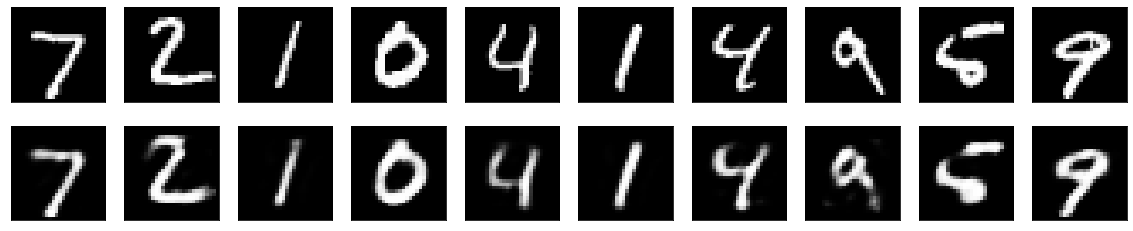

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
